In [10]:
from __future__ import print_function
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pickle
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from data import VOCroot, COCOroot, VOC_300, VOC_512, COCO_300, COCO_512, COCO_mobile_300, AnnotationTransform, \
    COCODetection, VOCDetection, detection_collate, BaseTransform, preproc, DOTADetection, DOTAroot,DotaAnnTrans,DOTA_CLASSES
import cv2
import torch.utils.data as data
from layers.functions import Detect,PriorBox
from utils.nms_wrapper import nms
from utils.timer import Timer

# 可视化依赖库
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Circle
import math

print(torch.__version__)

0.3.1


In [11]:
# params
trained_model = 'weights/RFB_vgg_subset_planes_500_gap200_300/2019-04-16-11:34/RFB_vgg_DOTA_epoches_160.pth'
train_sets = 'subset_planes_500_gap200'
img_dim = 300
DOTA_CLASSES = ('__background__', 'plane')
num_images = 1
num_classes = len(DOTA_CLASSES)
#img_path = '/home/raymond/project/PytorchSSD_DOTA/data/DOTA_devkit/examplesplit/images/P1088__1__2__4.png'
img_path = '/media/raymond/MainDrive/Dataset/DOTA/subset_planes_500_gap200/images/P1874__1__10__6.png'
rgb_means = (100.95,100.55,95.21) # RFB for voc
cuda = True
top_k = 200
cfg = VOC_300
detector = Detect(num_classes,0,cfg)
priorbox = PriorBox(cfg) # 锚框
priors = Variable(priorbox.forward(), volatile=True).cuda() # PyTorch版本不对，还要用Variable
max_per_image=300
thresh=0.005
rgb_std = (1, 1, 1)

In [12]:
# init net 
from models.RFB_Net_vgg import build_net
net = build_net(img_dim, num_classes,test=True)

# import trained_model
state_dict = torch.load(trained_model)

# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    head = k[:7]
    if head == 'module.':
        name = k[7:] # remove `module.`
    else:
        name = k
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)

# change mode to eval
# pytorch会自动把BN和DropOut固定住，不会取平均，而是用训练好的值
net.eval()
print('Finished loading model!')
# print(net)

Finished loading model!


In [13]:
# 传入一张图进行测试
img = cv2.imread(img_path,cv2.IMREAD_COLOR)
scale = torch.Tensor([img.shape[1], img.shape[0],img.shape[1], img.shape[0]])
x = Variable(BaseTransform(net.size, rgb_means, (2, 0, 1))(img).unsqueeze(0))
if cuda:
    x = x.cuda()
    scale = scale.cuda()
# 将图片传入网络进行计算
out = net(x)
print (out)
# 传入detector
boxes, scores = detector.forward(out,priors)
boxes = boxes[0]
scores = scores[0]
boxes *= scale
# 放入CPU，便于后续NMS
boxes = boxes.cpu().numpy()
scores = scores.cpu().numpy()

(Variable containing:
(  0  ,.,.) = 
  3.9559e-02  2.5091e-01 -1.5993e+00 -1.1437e+00
 -1.8672e-02 -3.4778e-02 -5.4441e-01 -2.0439e-01
 -2.2311e-01  1.8888e-01 -3.8246e+00 -1.0724e+00
                       ⋮                        
 -1.9869e-01  7.2144e-03 -8.9409e-01 -3.6547e-01
 -1.9450e-01  1.4555e-02 -9.6647e-01  5.0093e-01
 -3.0089e-01 -9.0953e-03  1.1988e-01 -5.6796e-01
[torch.cuda.FloatTensor of size 1x11620x4 (GPU 0)]
, Variable containing:
 0.9928  0.0072
 0.9938  0.0062
 0.9937  0.0063
       ⋮        
 0.9395  0.0605
 0.9370  0.0630
 0.9414  0.0586
[torch.cuda.FloatTensor of size 11620x2 (GPU 0)]
)


/home/raymond/project/PytorchSSD_DOTA/data/data_augment.py:254: RuntimeWarning: divide by zero encountered in true_divide
  img /= self.std
/home/raymond/project/PytorchSSD_DOTA/models/RFB_Net_vgg.py:215: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.softmax(conf.view(-1, self.num_classes)),  # conf preds


In [14]:
all_boxes = [[[] for _ in range(num_images)]for _ in range(num_classes)]
i=0
for j in range(1, num_classes):
    inds = np.where(scores[:, j] > thresh)[0]
    if len(inds) == 0:
        all_boxes[j][i] = np.empty([0, 5], dtype=np.float32)
        continue
    c_bboxes = boxes[inds]
    c_scores = scores[inds, j]
    c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(np.float32, copy=False)
    
    keep = nms(c_dets, 0.45, force_cpu=True) # 非极大抑制
    c_dets = c_dets[keep, :]
    all_boxes[j][i] = c_dets
if max_per_image > 0:
    image_scores = np.hstack([all_boxes[j][i][:, -1] for j in range(1,num_classes)]) #取出当前图像上非极大抑制后留下的所有框的置信度信息
    if len(image_scores) > max_per_image:
        image_thresh = np.sort(image_scores)[-max_per_image] #挑选出置信度阈值
        for j in range(1, num_classes):
            keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0] #挑选出置信度排名前max_per_image的预测框
            all_boxes[j][i] = all_boxes[j][i][keep, :]
# all_boxes 所有框
# all_boxes[num_class][num_image][num_box]
# box = [4个位置信息，1个置信度]
print((all_boxes[1][0][0]))

[  3.42152405e+01   7.84965897e+01   4.46335083e+02   4.22409119e+02
   6.29540086e-02]


image size is: (500, 500, 3)
(300, 5)
the number of boxes:  300 label: plane
[  3.42152405e+01   7.84965897e+01   4.46335083e+02   4.22409119e+02
   6.29540086e-02]
[  2.23507576e+01   1.68318295e+00   2.45484650e+02   1.56919952e+02
   6.05194271e-02]
[  6.47383041e+01  -2.20782871e+01   4.62710876e+02   1.38932602e+02
   6.03753999e-02]


/home/raymond/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


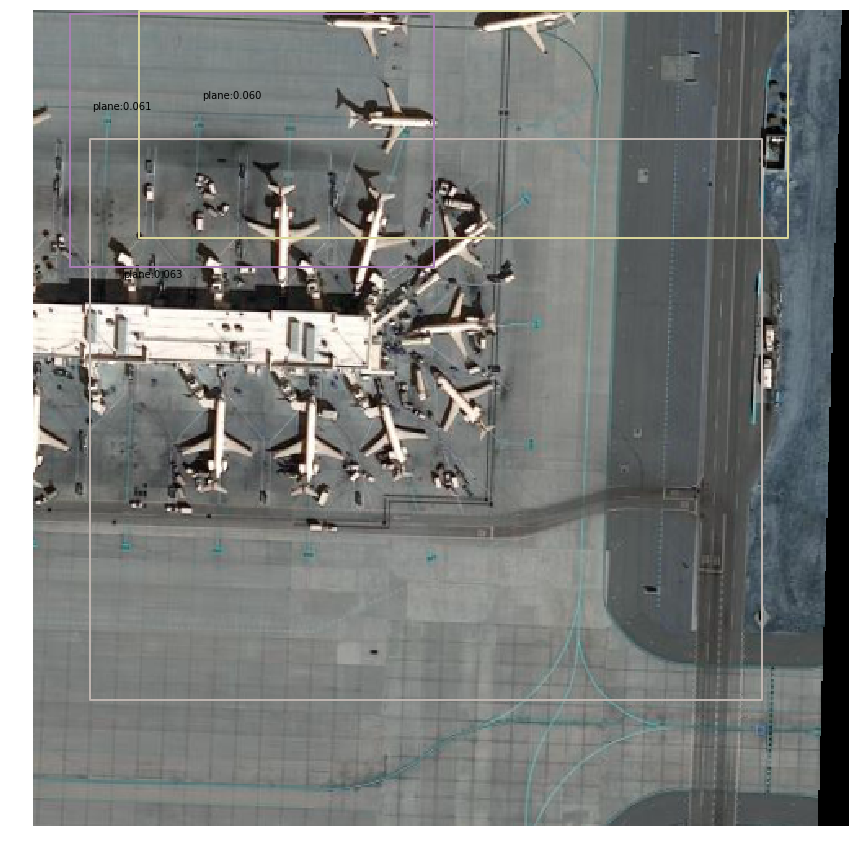

In [15]:
# 可视化
print('image size is:',img.shape)
plt.imshow(img)
plt.axis('off')
ax = plt.gca()
ax.set_autoscale_on(False)
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0) # 调整显示图像大小
polygons = []
color = []
circles = []
colors = [(0,0,0),(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128),(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0),(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128),(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
for k in range(1, num_classes):
    dets = all_boxes[k][i] # 一个种类的所有水平框
    print(dets.shape)
    if dets == []:
        continue
    print('the number of boxes: ', dets.shape[0], 'label:', DOTA_CLASSES[k])
    for s in range(dets.shape[0]): # 遍历所有框
        if dets[s][-1] >= 0.06:
            print (dets[s])
            c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] # 随机选颜色
            color.append(c)
            """
            xc,yc,w,h = dets[s][:4]
            xmin = xc - w/2
            xmax = xc + w/2
            ymin = yc - h/2
            ymax = yc + h/2
            """
            xmin,ymin,xmax,ymax = dets[s][:4]
            if xmin < 0: xmin =0
            if ymin < 0: ymin =0
            if xmax > img.shape[0]: xmax = img.shape[0]
            if ymax > img.shape[0]: ymax = img.shape[1]
            poly = [(xmin,ymax),(xmin,ymin),(xmax,ymin),(xmax,ymax)]
            polygons.append(Polygon(poly)) #append应该是允许多次画框
            # 标签
            text = DOTA_CLASSES[k]+ ':' + '{:.3f}'.format(dets[s, -1])
            #cv2.rectangle(img, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), (int(dets[s, 2] + 1),int(dets[s, 3] + 1)), colors[k], 2)
            #cv2.putText(img, text, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[k], 1)
            plt.annotate(text, xy=(int(xmin),int(ymax)),xytext=(int(xmin),int(ymax)), textcoords='offset points')
#p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
#ax.add_collection(p)
p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
ax.add_collection(p)

In [7]:
# TEST 
# Tuple to List
a = ('__background__', 'plane')
b = list(a)
b

['__background__', 'plane']

In [8]:
# TEST
# 获取Time
import time
time.strftime('%Y-%m-%d-%H:%M',time.localtime(time.time()))

'2019-04-16-18:01'

In [9]:
s = ' We  are ha ppy.  '
sl = list(s)
a = s.split(" ")
print(a)
res = ''
for i in range(len(a)-1):
    res += a[i]
    res += "%20"
res += a[-1]
res

['', 'We', '', 'are', 'ha', 'ppy.', '', '']


'%20We%20%20are%20ha%20ppy.%20%20'

In [10]:
image size is: (500, 500, 3)
(301, 5)
the number of boxes:  301 label: plane
[  3.93950562e+02   3.06878693e+02   5.70191650e+02   6.47699219e+02
   5.27598150e-02]
[  2.84121338e+02   3.97300476e+02   7.00333496e+02   5.55526245e+02
   5.09514920e-02]
image size is: (500, 500, 3)
(301, 5)
the number of boxes:  301 label: plane
[  3.93950562e+02   3.06878693e+02   5.70191650e+02   6.47699219e+02
   5.27598150e-02]
[  2.84121338e+02   3.97300476e+02   7.00333496e+02   5.55526245e+02
   5.09514920e-02]

SyntaxError: invalid syntax (<ipython-input-10-6ec2359de5f5>, line 1)

In [19]:
class Solution:
    def arrayPairSum(self, nums):
        """
        :type nums: List[int]
        :rtype: int
        """
        length = len(nums)
        res = 0
        while (length > 0):
            max_temp = max(nums)
            if length%2 != 0:
                res += max_temp
            nums.remove(max_temp)
            length -= 1
        return res
            
            
            

In [25]:
l = [2,3,7,5,1,2,43,4,7,3,8,9,]
l.sort()
print(l)
for i in range(0,len(l),2):
    print(l[i])

[1, 2, 2, 3, 3, 4, 5, 7, 7, 8, 9, 43]
1
2
3
5
7
9


In [24]:
type(min(1,2))

int